In [1]:
# Example python program to read data from a PostgreSQL table

# and load into a pandas DataFrame

import psycopg2

import pandas as pd

import re

from sqlalchemy import create_engine

In [2]:
dbUser = "postgres"
dbPassword = "postgres"
dbHostname = "localhost"
dbPort = 5432
dbName = "tinkoff"

connectionString = "postgresql://%s:%s@%s:%d/%s?sslmode=disable" % (dbUser, dbPassword, dbHostname, dbPort, dbName)
# Create an engine instance
alchemyEngine = create_engine(connectionString, pool_recycle=3600);

In [3]:
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
df = pd.read_sql("""
SELECT name, instrument.id, figi, ts, open_price, close_price, high_price, low_price, volume
FROM candle
LEFT JOIN instrument
 ON candle.instrument_id=instrument.id""", dbConnection);

pd.set_option('display.expand_frame_repr', False);

# Close the database connectio
dbConnection.close();

# Drop duplicates
df = df.drop_duplicates()

# Print the DataFrame
df.shape

(1596435, 9)

## Generate parquet

In [4]:
df.to_parquet("data.parquet", compression='gzip')

## Load parquet

In [2]:
df = pd.read_parquet("data.parquet")

In [3]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:00:00+00:00,114.02,114.02,114.02,114.02,16.0
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:00:00+00:00,114.43,114.23,114.43,114.16,314028.0
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 19:00:00+00:00,114.50,114.43,114.62,114.27,172536.0
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 18:00:00+00:00,114.43,114.50,114.64,114.40,151600.0
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 17:00:00+00:00,114.28,114.44,114.51,114.23,96186.0


## Limit instruments count

In [4]:
df = df[df["id"] <= 1]

In [5]:
instruments_count = df["id"].unique().size

## Preprocess data

In [6]:
metric_names = ['open_price','close_price','high_price','low_price','volume']

df_data_set = pd.DataFrame()

for metric_name in metric_names:
    # Pivot table and create data set part with single metric
    df_buf = df.pivot(index='ts', columns='id')[metric_name]
    
    # Rename column
    df_buf.columns = ['%s_%d' % (metric_name, x) for x in df_buf.columns]
    
    # Concat dataset
    df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Add timestamp features
df_data_set['year'] = df_data_set.index.year
df_data_set['month'] = df_data_set.index.month
df_data_set['day'] = df_data_set.index.day
df_data_set['weekday'] = df_data_set.index.weekday
df_data_set['hour'] = df_data_set.index.hour
df_data_set['minute'] = df_data_set.index.minute

# Add target column
target_name = 'open_price'
# Pivot table and create data set part with single metric
df_buf = df.pivot(index='ts', columns='id')[target_name]
# Add target metric
df_buf = df_buf.shift(-1)
# Rename column
df_buf.columns = ['target_%d' % x for x in df_buf.columns]
# Concat dataset
df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Fill NAN
df_data_set = df_data_set.fillna(method='ffill')

# Remove nan
df_data_set = df_data_set.dropna()

# Create non time columns list
data_columns_list = [x for x in df_data_set.columns if re.match('.*_\d+', x) is not None]

# Calc percentage
# df_data_set[data_columns_list] /= df_data_set[data_columns_list].iloc[0]
# Calc derivative for each column
# df_data_set[data_columns_list] = df_data_set[data_columns_list].diff()
# # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

# # Normalize data
# column_normalizer = {'year':3000, 'month':12, 'day':31, 'weekday':7, 'hour':24, 'minute':60}
# for column_name, normalizer_val in column_normalizer.items():
#     df_data_set[column_name] /= normalizer_val

# # Calc percentage
# # df_data_set /= df_data_set.iloc[0]
# # Calc derivative for each column
# df_data_set = df_data_set.diff()
# # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

print(df_data_set.shape)
df_data_set.describe()

(5585, 12)


,open_price_1,close_price_1,high_price_1,low_price_1,volume_1,year,month,day,weekday,hour,minute,target_1
count,5585.000000,5585.000000,5585.000000,5585.000000,5.585000e+03,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5585.0,5585.000000
mean,111.339828,111.337506,111.561094,111.107257,1.402297e+05,2018.604297,6.808594,15.762578,2.013071,15.063742,0.0,111.343506
std,7.590159,7.593885,7.573369,7.609060,1.736624e+05,0.489045,3.305114,8.701443,1.407871,4.335073,0.0,7.596664
min,91.220000,91.210000,91.820000,91.130000,1.000000e+00,2018.000000,1.000000,1.000000,0.000000,7.000000,0.0,91.220000
25%,106.350000,106.360000,106.590000,106.100000,6.300000e+01,2018.000000,4.000000,8.000000,1.000000,12.000000,0.0,106.350000
50%,110.500000,110.490000,110.770000,110.240000,1.073930e+05,2019.000000,7.000000,16.000000,2.000000,15.000000,0.0,110.500000
75%,114.770000,114.760000,114.980000,114.580000,2.379490e+05,2019.000000,10.000000,23.000000,3.000000,19.000000,0.0,114.780000
max,135.670000,135.670000,135.780000,135.480000,1.789360e+06,2019.000000,12.000000,31.000000,4.000000,23.000000,0.0,135.670000


<AxesSubplot:xlabel='ts'>

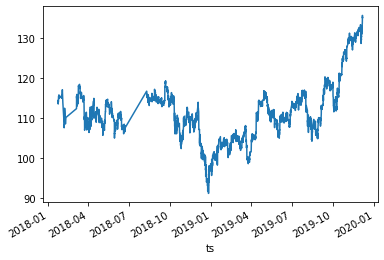

In [7]:
df_data_set.iloc[:,1].plot()

# Neural network

In [9]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from tensorflow.python.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

import numpy as np

import matplotlib.pyplot as plt

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11233910088516568433
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4501707077709236405
physical_device_desc: "device: XLA_CPU device"
]


In [13]:
y_size = instruments_count
X_size = df_data_set.shape[1] - y_size


# Cut features and targets
X = df_data_set.iloc[:,:X_size]
y = df_data_set.iloc[:,X_size:X_size+y_size]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# scale inputs with MinMaxScaler()
input_scaler =  MinMaxScaler()
# fit scaler
input_scaler.fit(X_train)
# transform training dataset
X_train = input_scaler.transform(X_train)
# transform test dataset
X_test = input_scaler.transform(X_test)

# Transform output with MinMaxScaler()
output_scaler = MinMaxScaler()
# fit scaler on training dataset
output_scaler.fit(y_train)
# transform training dataset
y_train = output_scaler.transform(y_train)
# transform test dataset
y_test = output_scaler.transform(y_test)

# Reshape and create loopback
look_back = 20

def reshape_with_look_back(look_back, dataset):
    output = np.ndarray(((dataset.shape[0] - look_back), look_back + 1, dataset.shape[1]))

    for i in range(look_back, dataset.shape[0]):
        output[i-look_back] = dataset[i-look_back:i+1]

    return output

# Create look back for input
X_train = reshape_with_look_back(look_back, X_train)
X_test = reshape_with_look_back(look_back, X_test)

# Adopt look back for output
y_train = y_train[look_back:]
y_test = y_test[look_back:]

# TODO Add forward days
# foward_days = 50

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4448, 21, 11)
(4448, 1)
(1097, 21, 11)
(1097, 1)


4448/4448 - 1s - loss: 0.0139 - mean_absolute_error: 0.1281 - val_loss: 0.0097 - val_mean_absolute_error: 0.1067
Epoch 15/1000
4448/4448 - 1s - loss: 0.0131 - mean_absolute_error: 0.1244 - val_loss: 0.0086 - val_mean_absolute_error: 0.1010
Epoch 16/1000
4448/4448 - 1s - loss: 0.0114 - mean_absolute_error: 0.1170 - val_loss: 0.0072 - val_mean_absolute_error: 0.0930
Epoch 17/1000
4448/4448 - 1s - loss: 0.0101 - mean_absolute_error: 0.1094 - val_loss: 0.0059 - val_mean_absolute_error: 0.0847
Epoch 18/1000
4448/4448 - 1s - loss: 0.0091 - mean_absolute_error: 0.1035 - val_loss: 0.0048 - val_mean_absolute_error: 0.0772
Epoch 19/1000
4448/4448 - 1s - loss: 0.0083 - mean_absolute_error: 0.0993 - val_loss: 0.0039 - val_mean_absolute_error: 0.0696
Epoch 20/1000
4448/4448 - 1s - loss: 0.0072 - mean_absolute_error: 0.0925 - val_loss: 0.0032 - val_mean_absolute_error: 0.0635
Epoch 21/1000
4448/4448 - 1s - loss: 0.0068 - mean_absolute_error: 0.0892 - val_loss: 0.0029 - val_mean_absolute_error: 0.059

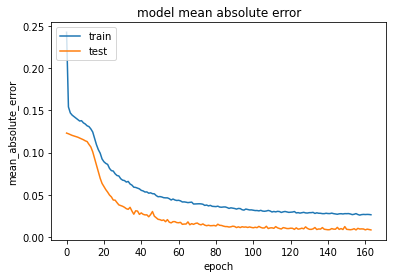

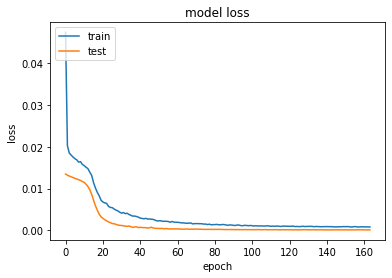

In [14]:
#Build the model
layer_size = 10

model = keras.Sequential()
model.add(layers.LSTM(units=layer_size,return_sequences=True,input_shape=(look_back + 1,X_size)))
model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(units=layer_size,return_sequences=True))
# model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(units=layer_size,return_sequences=True))
# model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=y_size))
model.compile(loss=losses.Huber(), optimizer='adam', metrics=['mae'])

print(model.summary())

# Create early stop
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
# fit model
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    validation_data=(X_test,y_test),
                    shuffle=True,
                    batch_size=100,
                    verbose=2,
                    callbacks=[es])

# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean absolute error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

(480, 21, 11)
(480, 1)


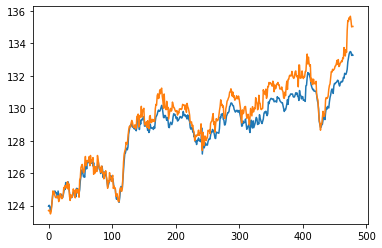

In [15]:
pred_elements_count = 500

# transform training dataset
X_scaled = input_scaler.transform(X[len(X)-pred_elements_count:])
X_scaled = reshape_with_look_back(look_back, X_scaled)

# transform training dataset
y_scaled = output_scaler.transform(y[len(y)-pred_elements_count:])

# Adopt look back for output
y_scaled = y_scaled[look_back:]

print(X_scaled.shape)
print(y_scaled.shape)

y_pred = model.predict(X_scaled)

plt.plot(output_scaler.inverse_transform(y_pred)[:,0])
plt.plot(output_scaler.inverse_transform(y_scaled)[:,0])
# plt.plot(y_pred_test[:,0])
# plt.plot(y_train.iloc[:,0].values)